In [98]:
import datetime
import inspect
import os
import pandas as pd
from PIL import Image

# import prefect   #need to be del
from prefect.tasks.shell import ShellTask
from prefect import Flow,task, Parameter
from prefect.schedules import IntervalSchedule
from prefect.engine.signals import SKIP
from prefect import context


In [99]:
@task
def filepath_prefect(Xfolder,SFolder,Folder,File):
    """
    Function to find parent path of cwd

    """    
    cwd = os.path.dirname(os.path.dirname(os.path.abspath(inspect.stack()[0][1])))
    read_file = os.path.join(cwd,Xfolder,SFolder,Folder,File)
    return read_file

In [100]:

def filepath(Xfolder,SFolder,Folder,File):
    """
    Function to find parent path of cwd
    filepath not as a prefect task. Avoids calling task functions from one another. 
    """
    cwd = os.path.dirname(os.path.dirname(os.path.abspath(inspect.stack()[0][1])))
    read_file = os.path.join(cwd,Xfolder,SFolder,Folder,File)
    return read_file

In [101]:
@task(skip_on_upstream_skip=False)
def git_command(url, target):
    """
    Returns the git to be passed to terminal. Skipping irrespective of upstream otherwise
    data wont be pulled everytime.
    """
    logger=prefect.context.get('logger')
    logger.info("=" * 50)
    logger.info("Git started cloning process from {url} to folder {target}".format(target=target, url=url))
    logger.info("=" * 50)
    
    return "! git clone {url} {target}".format(target=target, url=url)

In [102]:

@task
def rm_cmd(fpath):
    """
    Returns command to delete any data present in folder from previous runs without deleting folder.
    """

    logger=prefect.context.get('logger')
    logger.info("=" * 50)
    logger.info("Emptying the contents of folder {fpath}".format(fpath=fpath))
    logger.info("=" * 50) 

    return "rm -rf {fpath} ; mkdir -p {fpath}".format(fpath=fpath)


In [103]:
# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

"""
Functions to execute commands in terminal, one skips upsteream task while other doesnt
"""
git_clone = ShellTask(name="cloning", max_retries=2,skip_on_upstream_skip=False,retry_delay=datetime.timedelta(seconds=100))
remove_files = ShellTask(name="clearing_target_folder",max_retries=3, retry_delay=datetime.timedelta(seconds=40))

In [104]:
@task(max_retries=2, retry_delay=datetime.timedelta(seconds=5))
def filter_data(meta_path,img_folder):
    
    logger=prefect.context.get('logger')
    raw_data=pd.read_csv(meta_path)
    
    
    """
    Filtering X-ray for the following views PA,AP,AP Supine
    """      
    
    filter_list=['PA','AP','AP Supine']
    df=raw_data[raw_data['view'].isin(filter_list)]
    
    logger.info("=" * 50)
    logger.info("Filtering X-ray for the following views PA,AP,AP Supine")
    logger.info("=" * 50) 
    
    
    
    """
    Filtering data for which images exist.
    """  
        
    imgs_path=[file for file in os.listdir(img_folder)]
    df=df[df['filename'].isin(imgs_path)] 

    logger.info("=" * 50)
    logger.info("Filtering data for which image exists")
    logger.info("=" * 50) 
    
    """
    Filtering data on size of xrays
    """
    
    for item in df['filename']:
        df.loc[df['filename'] == item, 'height'],df.loc[df['filename'] == item, 'width']=Image.open(os.path.join(img_folder,item)).size
    df_included=df[(df['height']>1023) & (df['width']>1023)] 
    df_excluded=df[~df['filename'].isin(df_included['filename'])]

    logger.info("=" * 50)
    logger.info("Filtering data for Sizes")
    logger.info("=" * 50) 
    
    """
    Formatting data
    """
    
    df_included['fullfilepath']= str(img_folder) + "/"  + df['filename'].astype(str)
    df_excluded['fullfilepath']= str(img_folder) + "/"  + df['filename'].astype(str)
    
    df_excluded=df_excluded[['filename','height','width','fullfilepath']]
    
    return [df_included,df_excluded, df_included['fullfilepath'],df_excluded['fullfilepath']]


In [105]:
@task(skip_on_upstream_skip=False)
def load(metadata,result_location):
    """
    Storing images metadata in results
    """
    metadata[0].to_csv("{result_location}/files/images.csv_metadata".format(result_location=result_location))
    metadata[1].to_csv("{result_location}/files/excluded_images_metadata.csv".format(result_location=result_location))
    

In [106]:
@task(skip_on_upstream_skip=False)
def move_imgs(input_path,folder_name,result_location,images_list):
    """
    Moving images from data folder to result folder.
    """
    
    images_list.to_csv("{res}/files/{fname}_path.txt".format(res=result_location,fname=folder_name),header=False,index=False)
    
    logger=prefect.context.get('logger')
    logger.info("=" * 50)
    logger.info("Moving images to result")
    logger.info("=" * 50) 
    
    return "xargs mv -t {res}/{fn} < {res}/files/{fn}_path.txt".format(res=result_location,in_p=input_path,fn=folder_name)

In [107]:
# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

move=ShellTask(name="moving images", max_retries=2, retry_delay=datetime.timedelta(seconds=15),skip_on_upstream_skip=False)

In [108]:
schedule=IntervalSchedule(interval=datetime.timedelta(minutes=5))

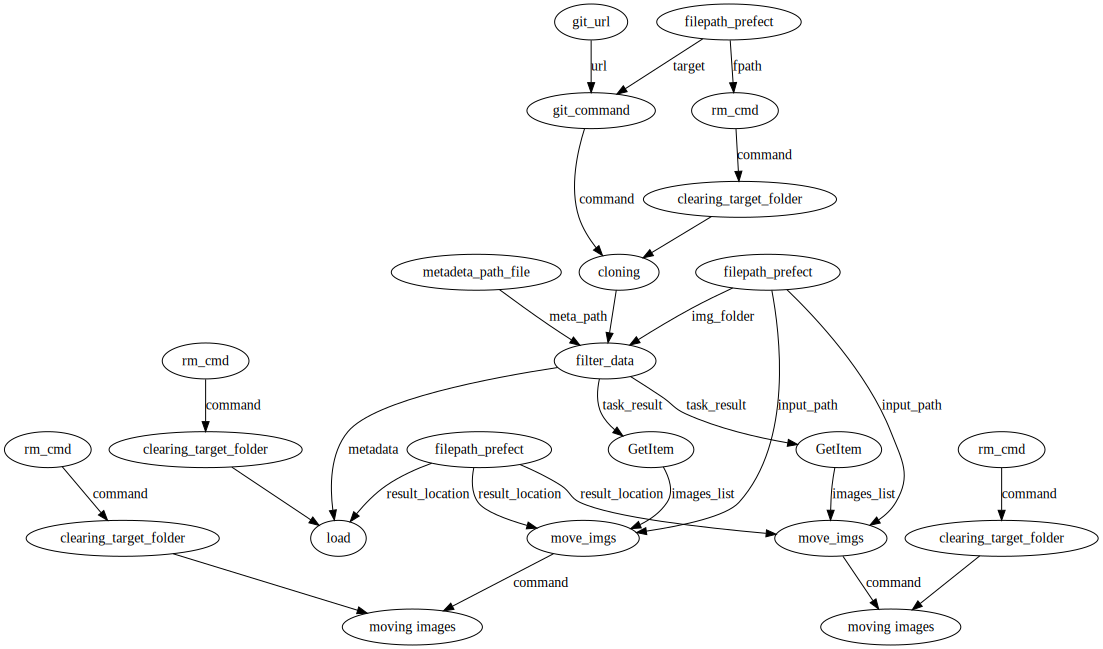

In [109]:
with Flow ('ETL') as flow:    
    #Input Parameters
    """
    use filepath_prefect to visualize in grater detail.
    """
          
    #user inputs 
    #dont change filepath for default in Parameter functions
    metadata_path=Parameter("metadeta_path_file",default=filepath("","","data","metadata.csv"))  
                                                    
    git_url = Parameter("git_url",
                  default="https://github.com/ieee8023/covid-chestxray-dataset")

    #folder structure inputs
    data_location=filepath_prefect("","","","data")
    images_folder=filepath_prefect("","","data","images")
    results_path=filepath_prefect("","","","results")
        
    """
    Extraction
    """
    
    #clearing data folder
    clear_data_location_cmd=rm_cmd(data_location)
    clearing_data_folder=remove_files(command=clear_data_location_cmd)
    
    #clearing results folders
    clear_res_files_location_cmd=rm_cmd(filepath("","","results","files"))
    clearing_res_files_folder=remove_files(command=clear_res_files_location_cmd)
    
    clear_res_images_location_cmd=rm_cmd(filepath("","","results","images"))
    clearing_res_images_folder=remove_files(command=clear_res_images_location_cmd)
    
    clear_excluded_images_location_cmd=rm_cmd(filepath("","","results","excluded_images"))
    clearing_excluded_images_folder=remove_files(command=clear_excluded_images_location_cmd)
    

    #Cloning git repo
    git_cmd = git_command(git_url,data_location)
    raw_data = git_clone(command=git_cmd,upstream_tasks=[clearing_data_folder])
    
    
    """
    Transform
    """
    metadata=filter_data(metadata_path,images_folder,upstream_tasks=[raw_data])
    
    
    """
    Loading
    """
    load(metadata,results_path,upstream_tasks=[clearing_res_files_folder])
    
    included_images_cmd=move_imgs(images_folder,'images',results_path,metadata[2])
    move(command=included_images_cmd,upstream_tasks=[clearing_res_images_folder])
    
    excluded_images_cmd=move_imgs(images_folder,'excluded_images',results_path,metadata[3])
    move(command=excluded_images_cmd,upstream_tasks=[clearing_excluded_images_folder])

flow.visualize()   

In [ ]:
flow.run()

In [ ]:
flow.register()